# Introduction: Problems in recurrent VGG16 

In this notebook, I show some problems I met when I try to recurrent VGG16 performence in CalTech101 


performence:
![performence in CalTech101](https://www.robots.ox.ac.uk/~vgg/research/very_deep/images/table_other.png)

# Training part 

below are some issues I think may effect accuracy.


## Problem 1: How to use dataset: CalTech 101

In the original text, the description of datatest:

In this section, we present the image classification results achieved by the described
ConvNet architectures on the ILSVRC-2012 dataset (which was used for ILSVRC 2012–2014 challenges). The dataset includes images of 1000 classes, and is split into three sets: training (1.3M
images), validation (50K images), and testing (100K images with held-out class labels).

unfortunately, I do not see any description of CalTech in original paper.

But in CalTech website, they said :

How to use the dataset
If you are using the Caltech 101 dataset for testing your recognition algorithm you should try and make your results comparable to the results of others. We suggest training and testing on fixed number of pictures and repeating the experiment with different random selections of pictures in order to obtain error bars. Popular number of training images: 1, 3, 5, 10, 15, 20, 30. Popular numbers of testing images: 20, 30. See also the discussion below.
When you report your results please keep track of which images you used and which were misclassified. We will soon publish a more detailed experimental protocol that allows you to report those details. See the Discussion section for more details.

[CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). 

There are about 40 to 800 images in each category. If we use the ratio in original paper: (26 : 1 : 2), some test sets only have 2 images, that is unreasonable smell. If we follow the seggustion of Caltech website, the traing set may too smell. below is the number of images in some classes when I set the ratio (5, 2.5, 2.5)

In [1]:
import os
import math
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

traindir = 'data/CalTech101(50, 25, 25)/train/'
validdir = 'data/CalTech101(50, 25, 25)/val/'
testdir = 'data/CalTech101(50, 25, 25)/test/'
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])



# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')
# Dataframe of training images
image_df = pd.DataFrame({'category': img_categories,'height': hs,'width': ws})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

cat_df.tail()
print (cat_df)

        category  n_train  n_valid  n_test
1      airplanes      400      200     200
65    Motorbikes      399      199     200
36         Faces      217      108     110
37    Faces_easy      217      108     110
94         watch      119       59      61
..           ...      ...      ...     ...
97      wild_cat       17        8       9
73      platypus       17        8       9
7      binocular       16        8       9
63     metronome       16        8       8
50  inline_skate       15        7       9

[101 rows x 4 columns]


## Problem 2: Batch size and iteration 



In the original text, the description of hypeparameters:

The batch size was set to 256, momentum to 0.9. The training was regularised by weight decay (the L2 penalty multiplier set to 5 · 10−4) and dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).
The learning rate was initially set to 10−2, and then decreased by a factor of 10 when the validation
set accuracy stopped improving. In total, the learning rate was decreased 3 times, and the learning
was stopped after 370K iterations (74 epochs). 


unfortunately, I cannot set the batch size to 256, because when I set the batch size to 32 or bigger than 32, the GPU will out of memory 

Because the batch size and number of images is different, the number of iterations will change.


## Problem 3: initialisation 


In the original text, the description of initialisation:

The initialisation of the network weights is important, since bad initialisation can stall learning due
to the instability of gradient in deep nets. To circumvent this problem, we began with training
the configuration A (Table 1), shallow enough to be trained with random initialisation. Then, when
training deeper architectures, we initialised the first four convolutional layers and the last three fullyconnected layers with the layers of net A (the intermediate layers were initialised randomly). We did
not decrease the learning rate for the pre-initialised layers, allowing them to change during learning.
For random initialisation (where applicable), we sampled the weights from a normal distribution
with the zero mean and 10−2 variance. The biases were initialised with zero. It is worth noting that
after the paper submission we found that it is possible to initialise the weights without pre-training
by using the random initialisation procedure of Glorot & Bengio (2010).

(The configuration A is VGG11)
It is easy to understand the step of random initialisation, But the problem is how to shallow enough pre-train the first four convolutional layers and the last three fullyconnected layers. How to judge it is enough. 

Previously, I just use the initialisation function from [Pytorch VGG model](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py). 
code in below



In [2]:
def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

## Problem 4: Training image size 


In the original text, the description of image size:

Training image size. Let S be the smallest side of an isotropically-rescaled training image, from
which the ConvNet input is cropped (we also refer to S as the training scale). While the crop size
is fixed to 224 × 224, in principle S can take on any value not less than 224: for S = 224 the crop
will capture whole-image statistics, completely spanning the smallest side of a training image; for
S ≫ 224 the crop will correspond to a small part of the image, containing a small object or an object
part.
We consider two approaches for setting the training scale S. The first is to fix S, which corresponds
to single-scale training (note that image content within the sampled crops can still represent multiscale image statistics). In our experiments, we evaluated models trained at two fixed scales: S =
256 (which has been widely used in the prior art (Krizhevsky et al., 2012; Zeiler & Fergus, 2013;
Sermanet et al., 2014)) and S = 384. Given a ConvNet configuration, we first trained the network
using S = 256. To speed-up training of the S = 384 network, it was initialised with the weights
pre-trained with S = 256, and we used a smaller initial learning rate of 10−3
.
The second approach to setting S is multi-scale training, where each training image is individually
rescaled by randomly sampling S from a certain range [Smin, Smax] (we used Smin = 256 and
Smax = 512). Since objects in images can be of different size, it is beneficial to take this into account
during training. This can also be seen as training set augmentation by scale jittering, where a single model is trained to recognise objects over a wide range of scales. For speed reasons, we trained
multi-scale models by fine-tuning all layers of a single-scale model with the same configuration,
pre-trained with fixed S = 384.

Now I understand randomly sampling, but I found the size of images in imagenet and CalTech 101 is different. the images in imagenet are more bigger. 
"The average image resolution on ImageNet is 469x387 pixels, normally there is a pre-processing that samples them to 256x256 as @Prune said." Maybe not true. I found in [stackoverflow](https://stackoverflow.com/questions/36109886/what-is-the-resolution-of-an-image-in-imagenet-dataset/36191512)

And the images size in CalTech 101 in below. 



In [3]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                            \
            count        mean        std    min    25%    50%    75%    max   
category                                                                      
Faces       217.0  333.940092  32.170424  252.0  312.0  329.0  351.0  468.0   
Faces_easy  217.0  319.884793  24.825700  237.0  303.0  319.0  333.0  381.0   
Leopards    100.0  138.880000  24.161611  128.0  128.0  128.0  128.0  192.0   
Motorbikes  399.0  164.523810  19.361382  121.0  151.0  163.0  175.0  261.0   
accordion    27.0  260.592593  37.212756  191.0  234.0  258.0  300.0  300.0   

            width                                                            
            count        mean        std    min    25%    50%    75%    max  
category                                                                     
Faces       217.0  505.686636  48.604064  382.0  473.0  499.0  532.0  708.0  
Faces_easy  217.0  274.405530  16.853991  248.0  266.0  273.0  282.0  417.0  
Leopards    100.0  181.120000  24.161611  128.0  192.0  192.0  192.0  192.0  
Motorbikes  399.0  262.556391   3.620323  231.0  261.0  261.0  263.0  278.0  
accordion    27.0  278.407407  31.715392  209.0  259.5  300.0  300.0  300.0

Text(0.5, 1.0, 'Average Size Distribution')

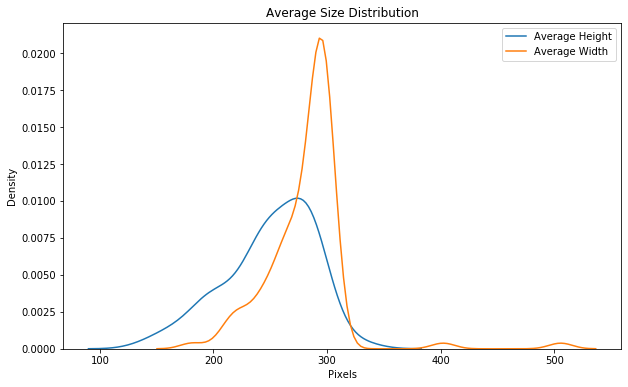

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')